# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [ ]:
#!pip3 -qq install torch==0.4.1
#!pip3 -qq install bokeh==0.13.0
#!pip3 -qq install gensim==3.6.0
#!pip3 -qq install nltk
#!pip3 -qq install scikit-learn==0.20.2

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor
    

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [2]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Kostya\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Kostya\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


Пример размеченного предложения:

In [3]:
for word, tag in data[0]:
    print(word, tag)
    #print('{:15}\t{}'.format(word, tag))

The DET
Fulton NOUN
County NOUN
Grand ADJ
Jury NOUN
said VERB
Friday NOUN
an DET
investigation NOUN
of ADP
Atlanta's NOUN
recent ADJ
primary NOUN
election NOUN
produced VERB
`` .
no DET
evidence NOUN
'' .
that ADP
any DET
irregularities NOUN
took VERB
place NOUN
. .


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [3]:
train_data, test_data = train_test_split(data, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 839670
Words count in val set: 147670
Words count in test set: 173852


Построим маппинги из слов в индекс и из тега в индекс:


In [4]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 48216. Tags = {'X', 'ADV', 'VERB', 'NOUN', 'PRT', 'ADJ', '.', 'NUM', 'CONJ', 'ADP', 'DET', 'PRON'}


In [27]:
Counter([1,2,3,1,2])

Counter({1: 2, 2: 2, 3: 1})

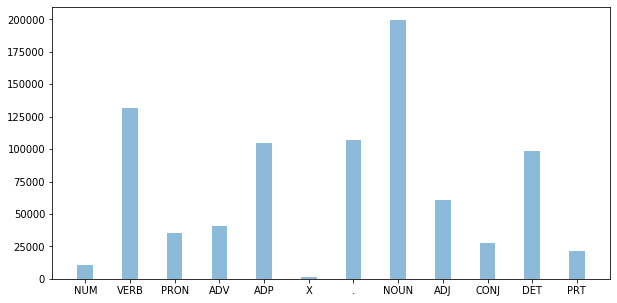

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [7]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.88%


Добавим вероятности переходов:

In [8]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.68%


Обратите внимание, что `backoff` важен:

In [9]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 24.71%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [5]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [6]:
batch_size = 4
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [8]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), batch_size))

X_batch.shape, 73
y_batch.shape

(32, 4)

In [9]:
y_batch

array([[11.,  7.,  8.,  6.],
       [12., 11.,  7.,  3.],
       [ 1., 12.,  3.,  7.],
       [11.,  4.,  7., 11.],
       [ 5.,  8.,  1., 12.],
       [12.,  7.,  8.,  7.],
       [ 8., 11.,  7.,  1.],
       [ 7., 12.,  7., 11.],
       [ 7.,  4., 12., 12.],
       [ 1.,  0.,  3.,  4.],
       [ 7.,  0., 12., 10.],
       [11.,  0.,  7.,  1.],
       [ 5.,  0.,  5., 11.],
       [12.,  0.,  6., 12.],
       [ 1.,  0., 12.,  6.],
       [11.,  0.,  7., 11.],
       [ 5.,  0.,  5., 12.],
       [ 4.,  0.,  4.,  4.],
       [ 5.,  0.,  6.,  0.],
       [ 4.,  0.,  3.,  0.],
       [ 6.,  0., 12.,  0.],
       [ 5.,  0.,  6.,  0.],
       [12.,  0., 12.,  0.],
       [ 1.,  0.,  3.,  0.],
       [ 5.,  0.,  3.,  0.],
       [12.,  0.,  7.,  0.],
       [ 4.,  0.,  6.,  0.],
       [ 0.,  0.,  7.,  0.],
       [ 0.,  0., 12.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0., 12.,  0.],
       [ 0.,  0.,  4.,  0.]])

**Задание** Реализуйте `LSTMTagger`:

In [10]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out.view(-1, self.hidden_dim))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [7]:
def get_accuracy(logits, y_batch):
    labels = torch.argmax(logits.view(y_batch.size()[0], y_batch.size()[1], -1), dim=2)
    mask = (y_batch != 0)
    cur_correct_count = float(torch.sum((labels == y_batch) * mask))
    cur_sum_count = float(mask.sum())
    return cur_correct_count/cur_sum_count

def train_model(model, train_data, val_data, loss, optimizer, scheduler, num_epochs, batch_size):    
    loss_history = []
    train_history = []
    val_history = []
    
    X_train, y_train = convert_data(train_data, word2ind, tag2ind)
    X_val, y_val = convert_data(val_data, word2ind, tag2ind)
    
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i, (X_batch, y_batch) in enumerate(iterate_batches((X_train, y_train), batch_size)):
    
            X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
            prediction = model(X_batch)
            loss_value = loss(prediction, y_batch.view(-1))
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_accum += loss_value

        ave_loss = loss_accum / i
        
        X_batch_train, y_batch_train = next(iterate_batches((X_train, y_train), 30))
        X_batch_val, y_batch_val = next(iterate_batches((X_val, y_val), 500))
        
        train_accuracy = get_accuracy(model(LongTensor(X_batch_train)), LongTensor(y_batch_train))
        val_accuracy = get_accuracy(model(LongTensor(X_batch_val)), LongTensor(y_batch_val))
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        if scheduler:
            scheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        

In [35]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
    ).cuda()

loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
loss_history, train_history, val_history = train_model(model, train_data, val_data, loss, optimizer, None, 5, 64)

Average loss: 0.300151, Train accuracy: 0.882051, Val accuracy: 0.861707
Average loss: 0.093069, Train accuracy: 0.939908, Val accuracy: 0.908186
Average loss: 0.063323, Train accuracy: 0.932534, Val accuracy: 0.922513
Average loss: 0.047900, Train accuracy: 0.941581, Val accuracy: 0.924728
Average loss: 0.038327, Train accuracy: 0.974705, Val accuracy: 0.923853


In [37]:
for i in model.lstm.parameters():
    print(i.data.shape)

torch.Size([512, 100])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])


### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

In [38]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
    ).cuda()

#weight=torch.ones(len(tag2ind)).cuda()
#weight[0] = 0

loss = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())
loss_history, train_history, val_history = train_model(model, train_data, val_data, loss, optimizer, None, 5, 64)

Average loss: 0.643398, Train accuracy: 0.899654, Val accuracy: 0.893388
Average loss: 0.253612, Train accuracy: 0.959215, Val accuracy: 0.931110
Average loss: 0.171866, Train accuracy: 0.954082, Val accuracy: 0.945741
Average loss: 0.128993, Train accuracy: 0.978548, Val accuracy: 0.947441
Average loss: 0.101005, Train accuracy: 0.984064, Val accuracy: 0.952796


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [12]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out.view(-1, self.hidden_dim*2))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
    ).cuda()

#weight=torch.ones(len(tag2ind)).cuda()
#weight[0] = 0

loss = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())
loss_history, train_history, val_history = train_model(model, train_data, val_data, loss, optimizer, None, 5, 64)

Average loss: 0.519992, Train accuracy: 0.928144, Val accuracy: 0.924605
Average loss: 0.188589, Train accuracy: 0.952694, Val accuracy: 0.949848
Average loss: 0.119007, Train accuracy: 0.978495, Val accuracy: 0.960714
Average loss: 0.080978, Train accuracy: 0.981994, Val accuracy: 0.967189
Average loss: 0.056214, Train accuracy: 0.991364, Val accuracy: 0.966182


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [8]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

In [10]:
w2v_model.most_similar('obama')

[('barack', 0.9372166395187378),
 ('bush', 0.927285373210907),
 ('clinton', 0.8960003852844238),
 ('mccain', 0.8875632882118225),
 ('gore', 0.8000321388244629),
 ('hillary', 0.7933661937713623),
 ('dole', 0.7851963043212891),
 ('rodham', 0.7518897652626038),
 ('romney', 0.7488930225372314),
 ('kerry', 0.7472623586654663)]

In [51]:
w2v_model['obama']

array([-0.44413  ,  0.59188  ,  0.98472  , -0.058361 ,  0.6077   ,
       -0.68421  ,  0.019399 ,  0.099464 , -0.13403  ,  0.24832  ,
       -0.24049  , -0.35876  , -0.29002  , -0.39814  ,  0.02137  ,
       -0.25071  , -0.013359 , -0.044295 , -0.29525  , -0.64601  ,
        0.29299  , -0.37601  , -0.3124   , -0.1293   , -0.93938  ,
        0.20459  , -0.72762  ,  0.2271   ,  0.44782  , -0.48476  ,
        0.7424   ,  1.1035   ,  0.6844   ,  0.86386  , -0.22639  ,
        0.68557  , -0.64844  , -0.48585  , -0.18262  ,  1.3293   ,
       -1.4314   , -0.95057  ,  0.94967  ,  0.55113  , -0.84357  ,
       -0.73851  , -0.13937  , -0.0097541, -0.28226  , -0.89138  ,
        0.15243  , -0.2845   ,  0.84001  ,  1.0873   , -0.016641 ,
       -2.5264   ,  0.50699  , -0.52419  ,  0.40204  ,  0.14475  ,
       -0.51315  ,  0.097834 ,  0.47384  , -0.67161  ,  0.52199  ,
        0.50871  ,  0.29222  ,  0.90184  , -0.2625   , -0.097745 ,
        0.21947  ,  0.12971  , -0.96543  , -0.20776  ,  0.0093

In [54]:
w2v_model.vectors.shape

(400000, 100)

In [56]:
w2v_model.vocab

{'the': <gensim.models.keyedvectors.Vocab at 0x1f4ff3ee7c8>,
 ',': <gensim.models.keyedvectors.Vocab at 0x1f4ff3eb8c8>,
 '.': <gensim.models.keyedvectors.Vocab at 0x1f4ff3ee808>,
 'of': <gensim.models.keyedvectors.Vocab at 0x1f4ff3eb108>,
 'to': <gensim.models.keyedvectors.Vocab at 0x1f4ff3ee888>,
 'and': <gensim.models.keyedvectors.Vocab at 0x1f4ff3eb448>,
 'in': <gensim.models.keyedvectors.Vocab at 0x1f4ff3ee948>,
 'a': <gensim.models.keyedvectors.Vocab at 0x1f4ff3eb488>,
 '"': <gensim.models.keyedvectors.Vocab at 0x1f4ff3ee988>,
 "'s": <gensim.models.keyedvectors.Vocab at 0x1f4ff3cb588>,
 'for': <gensim.models.keyedvectors.Vocab at 0x1f4ff3ee9c8>,
 '-': <gensim.models.keyedvectors.Vocab at 0x1f4ff3cb788>,
 'that': <gensim.models.keyedvectors.Vocab at 0x1f4ff3eea08>,
 'on': <gensim.models.keyedvectors.Vocab at 0x1f4ff3cbf48>,
 'is': <gensim.models.keyedvectors.Vocab at 0x1f4ff3eea88>,
 'was': <gensim.models.keyedvectors.Vocab at 0x1f4ff3cb888>,
 'said': <gensim.models.keyedvectors.Vo

In [57]:
w2v_model.get_vector('he')

array([ 0.1225   , -0.058833 ,  0.23658  , -0.28877  , -0.028181 ,
        0.31524  ,  0.070229 ,  0.16447  , -0.027623 ,  0.25214  ,
        0.21174  , -0.059674 ,  0.36133  ,  0.13607  ,  0.18755  ,
       -0.1487   ,  0.31315  ,  0.13368  , -0.59703  , -0.030161 ,
        0.080656 ,  0.26162  , -0.055924 , -0.35351  ,  0.34722  ,
       -0.0055801, -0.57935  , -0.88007  ,  0.42931  , -0.15695  ,
       -0.51256  ,  1.2684   , -0.25228  ,  0.35265  , -0.46419  ,
        0.55648  , -0.57556  ,  0.32574  , -0.21893  , -0.13178  ,
       -1.1027   , -0.039591 ,  0.89643  , -0.9845   , -0.47393  ,
       -0.12855  ,  0.63506  , -0.94888  ,  0.40088  , -0.77542  ,
       -0.35153  , -0.27788  ,  0.68747  ,  1.458    , -0.38474  ,
       -2.8937   , -0.29523  , -0.38836  ,  0.94881  ,  1.3891   ,
        0.054591 ,  0.70486  , -0.65699  ,  0.075648 ,  0.7655   ,
       -0.63365  ,  0.86556  ,  0.42441  ,  0.14796  ,  0.4156   ,
        0.29354  , -0.51295  ,  0.19635  , -0.45568  ,  0.0080

Построим подматрицу для слов из нашей тренировочной выборки:

In [9]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 40781 out of 48216 word embeddings


In [58]:
embeddings

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.45799994e-01, -7.76759982e-02,  5.09069979e-01, ...,
         3.16980004e-01,  6.43890023e-01,  2.62160003e-01],
       [-4.45060015e-01,  2.14609995e-01,  7.40369976e-01, ...,
        -4.09920007e-01,  3.43010008e-01,  7.01040030e-01],
       ...,
       [-4.01019990e-01,  3.93939990e-04, -4.27810013e-01, ...,
         6.38029993e-01,  3.07130009e-01,  1.01950002e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-5.74599981e-01,  3.35500002e-01,  2.98929989e-01, ...,
         3.15259993e-02,  2.77859997e-02, -5.68629980e-01]])

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [13]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=100, hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional = True)
        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out.view(-1, self.hidden_dim*2))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
model = LSTMTaggerWithPretrainedEmbs(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
    ).cuda()

#weight=torch.ones(len(tag2ind)).cuda()
#weight[0] = 0

loss = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())
loss_history, train_history, val_history = train_model(model, train_data, val_data, loss, optimizer, None, 5, 64)

AttributeError: 'numpy.ndarray' object has no attribute 'dim'